In [243]:
import math
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder 
from collections import Counter
from scipy import stats
%matplotlib inline

df_test = pd.read_csv("C:/Users/Mario/Desktop/UniPi/1° semestre/Data Mining 1/Datasets/DatasetProject1/Test_HR_Employee_Attrition.csv")
df_train = pd.read_csv("C:/Users/Mario/Desktop/UniPi/1° semestre/Data Mining 1/Datasets/DatasetProject1/Train_HR_Employee_Attrition.csv")

frame = [df_test, df_train]
df3 = pd.concat(frame)
df3.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,27.0,Yes,Travel_Frequently,763,Sales,15,2,Medical,1,Male,...,4,80.0,2,7,1.0,2,2.0,2,2,2
1,30.0,Yes,Travel_Rarely,1079,Sales,16,4,Marketing,1,Male,...,1,NaN,3,10,2.0,3,8.0,0,0,0
2,56.0,No,Non-Travel,150,Research & Development,2,4,Technical Degree,4,Male,...,3,80.0,1,12,2.0,2,13.0,3,1,4
3,41.0,Yes,NaN,359,Human Resources,18,5,Human Resources,4,Male,...,3,80.0,0,2,4.0,3,3.0,0,0,0
4,42.0,No,NaN,642,Research & Development,1,3,Life Sciences,4,Male,...,1,NaN,1,12,6.0,3,5.0,3,1,0


**DATA UNDERSTANDING**

In [244]:
#HO AGGIUNTO PER PROVA "MonthlyIncome", "YearsWithCurrManager", "YearsSinceLastPromotion", "TrainingTimesLastYear", "NumCompaniesWorked", "MaritalStatus", "PerformanceRating"
       
new_df = df3[['Age', 'Attrition', 'BusinessTravel',  'Department', 'DistanceFromHome', 'Education', 'EducationField','HourlyRate',
       'EnvironmentSatisfaction','Gender',  'JobLevel',  'JobSatisfaction', 'OverTime', 'PercentSalaryHike', 'WorkLifeBalance',
        "MonthlyIncome", "TrainingTimesLastYear", "NumCompaniesWorked", "MaritalStatus", "PerformanceRating", 
        'TotalWorkingYears', 'YearsAtCompany',"YearsSinceLastPromotion", "YearsInCurrentRole", "YearsWithCurrManager"]]

#new_df.head()

In [245]:
#Riempio i valori mancanti
valori = {"Age": new_df["Age"].mean(),
          "Gender": "Male", 
          "BusinessTravel": "Travel_Rarely", 
          "YearsAtCompany": new_df["YearsAtCompany"].median(),
          "TrainingTimesLastYear": new_df["TrainingTimesLastYear"].median(),
          "PerformanceRating": new_df["PerformanceRating"].median()}

new_df = new_df.fillna(value=valori)

#Separo new_df in due dataset, uno filtrato per Male e uno per Female 
male_df = new_df[new_df["Gender"] == "Male"]
female_df = new_df[new_df["Gender"] == "Female"]

#Sostituisco i valori vuoti di MonthlyIncome con la mediana per Male
male_income = {"MonthlyIncome": 4865.5}
male_df = male_df.fillna(value=male_income)

#Sostituisco i valori vuoti di MonthlyIncome con la mediana per Female
female_income = {"MonthlyIncome": 5197.0}
female_df = female_df.fillna(value=female_income)

#Riunisco i dataset che avevo separato, con tutti i missing values riempiti
frame = [male_df, female_df]
new_df = pd.concat(frame)

#df contiene il dataset con i missing values riempiti
df = new_df
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,HourlyRate,EnvironmentSatisfaction,Gender,...,MonthlyIncome,TrainingTimesLastYear,NumCompaniesWorked,MaritalStatus,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsInCurrentRole,YearsWithCurrManager
0,27.0,Yes,Travel_Frequently,Sales,15,2,Medical,59,1,Male,...,4298.0,1.0,6,Divorced,3.0,7,2.0,2,2,2
1,30.0,Yes,Travel_Rarely,Sales,16,4,Marketing,70,1,Male,...,5304.0,2.0,2,Married,4.0,10,8.0,0,0,0
2,56.0,No,Non-Travel,Research & Development,2,4,Technical Degree,60,4,Male,...,6306.0,2.0,2,Divorced,4.0,12,13.0,1,3,4
3,41.0,Yes,Travel_Rarely,Human Resources,18,5,Human Resources,89,4,Male,...,6430.0,4.0,0,Married,3.0,2,3.0,0,0,0
4,42.0,No,Travel_Rarely,Research & Development,1,3,Life Sciences,76,4,Male,...,2766.0,6.0,3,Married,4.0,12,5.0,1,3,0


**OUTLIER DETECTION**

In [246]:
#Metodo con IQR
TotalWorkingYears_Q1 = df.TotalWorkingYears.quantile(0.25)
TotalWorkingYears_Q3 = df.TotalWorkingYears.quantile(0.75)
TotalWorkingYears_IQR = TotalWorkingYears_Q3 - TotalWorkingYears_Q1
lower = TotalWorkingYears_Q1 - 1.5*TotalWorkingYears_IQR
upper = TotalWorkingYears_Q3 + 1.5*TotalWorkingYears_IQR
print("IQR: ", df[ (df["TotalWorkingYears"]<lower) | (df["TotalWorkingYears"]>upper) ].shape)

#Metodo con ZSCORE
df["TWYears_zscore"] = (df.TotalWorkingYears - df.TotalWorkingYears.mean())/df.TotalWorkingYears.std()
print("ZSCORE: ", df[ (df["TWYears_zscore"]<-3) | (df["TWYears_zscore"]>3) ].shape)

#Metodo con STD
TotalWorkingYears_UL = df.TotalWorkingYears.mean() + 3*df.TotalWorkingYears.std()
TotalWorkingYears_LL = df.TotalWorkingYears.mean() - 3*df.TotalWorkingYears.std()
print("STD: ",df[df.TotalWorkingYears > TotalWorkingYears_UL].shape)

IQR:  (63, 25)
ZSCORE:  (16, 26)
STD:  (16, 26)


In [247]:
#Metodo con IQR
YearsAtCompany_Q1 = df.YearsAtCompany.quantile(0.25)
YearsAtCompany_Q3 = df.YearsAtCompany.quantile(0.75)
YearsAtCompany_IQR = YearsAtCompany_Q3 - YearsAtCompany_Q1
lower = YearsAtCompany_Q1 - 1.5*YearsAtCompany_IQR
upper = YearsAtCompany_Q3 + 1.5*YearsAtCompany_IQR
print("IQR: ", df[ (df["YearsAtCompany"]<lower) | (df["YearsAtCompany"]>upper) ].shape)

#Metodo con ZSCORE
df["YearsAtCompany_zscore"] = (df.YearsAtCompany - df.YearsAtCompany.mean())/df.YearsAtCompany.std()
print("ZSCORE: ", df[ (df["YearsAtCompany_zscore"]<-3) | (df["YearsAtCompany_zscore"]>3) ].shape)

#Metodo con STD
YearsAtCompany_UL = df.YearsAtCompany.mean() + 3*df.YearsAtCompany.std()
YearsAtCompany_LL = df.YearsAtCompany.mean() - 3*df.YearsAtCompany.std()
print("STD: ", df[df.YearsAtCompany > YearsAtCompany_UL].shape)

IQR:  (94, 26)
ZSCORE:  (24, 27)
STD:  (24, 27)


In [248]:
#Metodo con IQR
YearsInCurrentRole_Q1 = df.YearsInCurrentRole.quantile(0.25)
YearsInCurrentRole_Q3 = df.YearsInCurrentRole.quantile(0.75)
YearsInCurrentRole_IQR = YearsInCurrentRole_Q3 - YearsInCurrentRole_Q1
lower = YearsInCurrentRole_Q1 - 1.5*YearsInCurrentRole_IQR
upper = YearsInCurrentRole_Q3 + 1.5*YearsInCurrentRole_IQR
print("IQR: ", df[ (df["YearsInCurrentRole"]<lower) | (df["YearsInCurrentRole"]>upper) ].shape)

#Metodo con ZSCORE
df["YearsInCurrentRole_zscore"] = (df.YearsInCurrentRole - df.YearsInCurrentRole.mean())/df.YearsInCurrentRole.std()
print("ZSCORE: ", df[ (df["YearsInCurrentRole_zscore"]<-3) | (df["YearsInCurrentRole_zscore"]>3) ].shape)

#Metodo con STD
YearsInCurrentRole_UL = df.YearsInCurrentRole.mean() + 3*df.YearsInCurrentRole.std()
YearsInCurrentRole_LL = df.YearsInCurrentRole.mean() - 3*df.YearsInCurrentRole.std()
print("STD: ", df[df.YearsInCurrentRole > YearsInCurrentRole_UL].shape)

IQR:  (21, 27)
ZSCORE:  (13, 28)
STD:  (13, 28)


In [249]:
#Metodo con IQR
YearsWithCurrManager_Q1 = df.YearsWithCurrManager.quantile(0.25)
YearsWithCurrManager_Q3 = df.YearsWithCurrManager.quantile(0.75)
YearsWithCurrManager_IQR = YearsWithCurrManager_Q3 - YearsWithCurrManager_Q1
lower = YearsWithCurrManager_Q1 - 1.5*YearsWithCurrManager_IQR
upper = YearsWithCurrManager_Q3 + 1.5*YearsWithCurrManager_IQR
print("IQR: ", df[ (df["YearsWithCurrManager"]<lower) | (df["YearsWithCurrManager"]>upper) ].shape)

#Metodo con ZSCORE
df["YearsWithCurrManager_zscore"] = (df.YearsWithCurrManager - df.YearsWithCurrManager.mean())/df.YearsWithCurrManager.std()
print("ZSCORE: ", df[ (df["YearsWithCurrManager_zscore"]<-3) | (df["YearsWithCurrManager_zscore"]>3) ].shape)

#Metodo con STD
YearsWithCurrManager_UL = df.YearsWithCurrManager.mean() + 3*df.YearsWithCurrManager.std()
YearsWithCurrManager_LL = df.YearsWithCurrManager.mean() - 3*df.YearsWithCurrManager.std()
print("STD: ", df[df.YearsWithCurrManager > YearsWithCurrManager_UL].shape)

IQR:  (14, 28)
ZSCORE:  (14, 29)
STD:  (14, 29)


In [250]:
#Metodo con IQR
YearsSinceLastPromotion_Q1 = df.YearsSinceLastPromotion.quantile(0.25)
YearsSinceLastPromotion_Q3 = df.YearsSinceLastPromotion.quantile(0.75)
YearsSinceLastPromotion_IQR = YearsSinceLastPromotion_Q3 - YearsSinceLastPromotion_Q1
lower = YearsSinceLastPromotion_Q1 - 1.5*YearsSinceLastPromotion_IQR
upper = YearsSinceLastPromotion_Q3 + 1.5*YearsSinceLastPromotion_IQR
print("IQR: ", df[ (df["YearsSinceLastPromotion"]<lower) | (df["YearsSinceLastPromotion"]>upper) ].shape)

#Metodo con ZSCORE
df["YearsSinceLastPromotion_zscore"] = (df.YearsSinceLastPromotion - df.YearsSinceLastPromotion.mean())/df.YearsSinceLastPromotion.std()
print("ZSCORE: ", df[ (df["YearsSinceLastPromotion_zscore"]<-3) | (df["YearsSinceLastPromotion_zscore"]>3) ].shape)

#Metodo con STD
YearsSinceLastPromotion_UL = df.YearsSinceLastPromotion.mean() + 3*df.YearsSinceLastPromotion.std()
YearsSinceLastPromotion_LL = df.YearsSinceLastPromotion.mean() - 3*df.YearsSinceLastPromotion.std()
print("STD: ", df[df.YearsSinceLastPromotion > YearsSinceLastPromotion_UL].shape)

IQR:  (107, 29)
ZSCORE:  (42, 30)
STD:  (42, 30)


In [271]:
print("Totale outliers")
print("IQR: ", sum([63,94,21,14,107]))
print("ZSCORE: ", sum([16,24,13,14,42]))
print("STD: ", sum([16,24,13,14,42]))

Totale outliers
IQR:  299
ZSCORE:  109
STD:  109


**LOG-TRANSFORMATION**

In [252]:
log_df = df[["TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole", "YearsWithCurrManager", "YearsSinceLastPromotion"]]
log_df = np.log1p(log_df)
log_df.head()

,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,YearsSinceLastPromotion
0,2.079442,1.098612,1.098612,1.098612,1.098612
1,2.397895,2.197225,0.000000,0.000000,0.000000
2,2.564949,2.639057,1.386294,1.609438,0.693147
3,1.098612,1.386294,0.000000,0.000000,0.000000
4,2.564949,1.791759,1.386294,0.000000,0.693147


In [253]:
#Metodo con IQR
TotalWorkingYears_Q1 = log_df.TotalWorkingYears.quantile(0.25)
TotalWorkingYears_Q3 = log_df.TotalWorkingYears.quantile(0.75)
TotalWorkingYears_IQR = TotalWorkingYears_Q3 - TotalWorkingYears_Q1
lower = TotalWorkingYears_Q1 - 1.5*TotalWorkingYears_IQR
upper = TotalWorkingYears_Q3 + 1.5*TotalWorkingYears_IQR
print("IQR: ", log_df[ (log_df["TotalWorkingYears"]<lower) | (log_df["TotalWorkingYears"]>upper) ].shape)

#Metodo con ZSCORE
log_df["TWYears_zscore"] = (log_df.TotalWorkingYears - log_df.TotalWorkingYears.mean())/log_df.TotalWorkingYears.std()
print("ZSCORE: ", log_df[ (log_df["TWYears_zscore"]<-3) | (log_df["TWYears_zscore"]>3) ].shape)

#Metodo con STD
TotalWorkingYears_UL = log_df.TotalWorkingYears.mean() + 3*log_df.TotalWorkingYears.std()
TotalWorkingYears_LL = log_df.TotalWorkingYears.mean() - 3*log_df.TotalWorkingYears.std()
print("STD: ",log_df[log_df.TotalWorkingYears > TotalWorkingYears_UL].shape)

IQR:  (92, 5)
ZSCORE:  (11, 6)
STD:  (0, 6)


In [254]:
#Metodo con IQR
YearsAtCompany_Q1 = log_df.YearsAtCompany.quantile(0.25)
YearsAtCompany_Q3 = log_df.YearsAtCompany.quantile(0.75)
YearsAtCompany_IQR = YearsAtCompany_Q3 - YearsAtCompany_Q1
lower = YearsAtCompany_Q1 - 1.5*YearsAtCompany_IQR
upper = YearsAtCompany_Q3 + 1.5*YearsAtCompany_IQR
print("IQR: ", log_df[ (log_df["YearsAtCompany"]<lower) | (log_df["YearsAtCompany"]>upper) ].shape)

#Metodo con ZSCORE
log_df["YearsAtCompany_zscore"] = (log_df.YearsAtCompany - log_df.YearsAtCompany.mean())/log_df.YearsAtCompany.std()
print("ZSCORE: ", log_df[ (log_df["YearsAtCompany_zscore"]<-3) | (log_df["YearsAtCompany_zscore"]>3) ].shape)

#Metodo con STD
YearsAtCompany_UL = log_df.YearsAtCompany.mean() + 3*log_df.YearsAtCompany.std()
YearsAtCompany_LL = log_df.YearsAtCompany.mean() - 3*log_df.YearsAtCompany.std()
print("STD: ", log_df[log_df.YearsAtCompany > YearsAtCompany_UL].shape)

IQR:  (42, 6)
ZSCORE:  (0, 7)
STD:  (0, 7)


In [255]:
#Metodo con IQR
YearsInCurrentRole_Q1 = log_df.YearsInCurrentRole.quantile(0.25)
YearsInCurrentRole_Q3 = log_df.YearsInCurrentRole.quantile(0.75)
YearsInCurrentRole_IQR = YearsInCurrentRole_Q3 - YearsInCurrentRole_Q1
lower = YearsInCurrentRole_Q1 - 1.5*YearsInCurrentRole_IQR
upper = YearsInCurrentRole_Q3 + 1.5*YearsInCurrentRole_IQR
print("IQR: ", log_df[ (log_df["YearsInCurrentRole"]<lower) | (log_df["YearsInCurrentRole"]>upper) ].shape)

#Metodo con ZSCORE
log_df["YearsInCurrentRole_zscore"] = (log_df.YearsInCurrentRole - log_df.YearsInCurrentRole.mean())/log_df.YearsInCurrentRole.std()
print("ZSCORE: ", log_df[ (log_df["YearsInCurrentRole_zscore"]<-3) | (log_df["YearsInCurrentRole_zscore"]>3) ].shape)

#Metodo con STD
YearsInCurrentRole_UL = log_df.YearsInCurrentRole.mean() + 3*log_df.YearsInCurrentRole.std()
YearsInCurrentRole_LL = log_df.YearsInCurrentRole.mean() - 3*log_df.YearsInCurrentRole.std()
print("STD: ", log_df[log_df.YearsInCurrentRole > YearsInCurrentRole_UL].shape)

IQR:  (0, 7)
ZSCORE:  (0, 8)
STD:  (0, 8)


In [256]:
#Metodo con IQR
YearsWithCurrManager_Q1 = log_df.YearsWithCurrManager.quantile(0.25)
YearsWithCurrManager_Q3 = log_df.YearsWithCurrManager.quantile(0.75)
YearsWithCurrManager_IQR = YearsWithCurrManager_Q3 - YearsWithCurrManager_Q1
lower = YearsWithCurrManager_Q1 - 1.5*YearsWithCurrManager_IQR
upper = YearsWithCurrManager_Q3 + 1.5*YearsWithCurrManager_IQR
print("IQR: ", log_df[ (log_df["YearsWithCurrManager"]<lower) | (log_df["YearsWithCurrManager"]>upper) ].shape)

#Metodo con ZSCORE
log_df["YearsWithCurrManager_zscore"] = (log_df.YearsWithCurrManager - log_df.YearsWithCurrManager.mean())/log_df.YearsWithCurrManager.std()
print("ZSCORE: ", log_df[ (log_df["YearsWithCurrManager_zscore"]<-3) | (log_df["YearsWithCurrManager_zscore"]>3) ].shape)

#Metodo con STD
YearsWithCurrManager_UL = log_df.YearsWithCurrManager.mean() + 3*log_df.YearsWithCurrManager.std()
YearsWithCurrManager_LL = log_df.YearsWithCurrManager.mean() - 3*log_df.YearsWithCurrManager.std()
print("STD: ", log_df[log_df.YearsWithCurrManager > YearsWithCurrManager_UL].shape)

IQR:  (0, 8)
ZSCORE:  (0, 9)
STD:  (0, 9)


In [257]:
#Metodo con IQR
YearsSinceLastPromotion_Q1 = log_df.YearsSinceLastPromotion.quantile(0.25)
YearsSinceLastPromotion_Q3 = log_df.YearsSinceLastPromotion.quantile(0.75)
YearsSinceLastPromotion_IQR = YearsSinceLastPromotion_Q3 - YearsSinceLastPromotion_Q1
lower = YearsSinceLastPromotion_Q1 - 1.5*YearsSinceLastPromotion_IQR
upper = YearsSinceLastPromotion_Q3 + 1.5*YearsSinceLastPromotion_IQR
print("IQR: ", log_df[ (log_df["YearsSinceLastPromotion"]<lower) | (log_df["YearsSinceLastPromotion"]>upper) ].shape)

#Metodo con ZSCORE
log_df["YearsSinceLastPromotion_zscore"] = (log_df.YearsSinceLastPromotion - log_df.YearsSinceLastPromotion.mean())/log_df.YearsSinceLastPromotion.std()
print("ZSCORE: ", log_df[ (log_df["YearsSinceLastPromotion_zscore"]<-3) | (log_df["YearsSinceLastPromotion_zscore"]>3) ].shape)

#Metodo con STD
YearsSinceLastPromotion_UL = log_df.YearsSinceLastPromotion.mean() + 3*log_df.YearsSinceLastPromotion.std()
YearsSinceLastPromotion_LL = log_df.YearsSinceLastPromotion.mean() - 3*log_df.YearsSinceLastPromotion.std()
print("STD: ", log_df[log_df.YearsSinceLastPromotion > YearsSinceLastPromotion_UL].shape)

IQR:  (0, 9)
ZSCORE:  (0, 10)
STD:  (0, 10)


In [272]:
print("Totale outliers dopo una log-transormation")
print("IQR: ", sum([92,42,0,0,0]))
print("ZSCORE: ", sum([11,0,0,0,0]))
print("STD: ", sum([0,0,0,0,0]))

Totale outliers dopo una log-transormation
IQR:  134
ZSCORE:  11
STD:  0


In [277]:
filtro = df[["Age","YearsAtCompany", "TotalWorkingYears"]]
filtro[filtro["TotalWorkingYears"] < filtro["YearsAtCompany"]]

,Age,YearsAtCompany,TotalWorkingYears
2,56.000000,13.0,12
3,41.000000,3.0,2
5,42.000000,20.0,10
17,37.115262,16.0,6
23,26.000000,8.0,6
...,...,...,...
1132,36.000000,16.0,5
1168,32.000000,14.0,6
1170,38.000000,10.0,1
1171,37.000000,17.0,1


In [278]:
filtro[filtro["TotalWorkingYears"] == 0]

,Age,YearsAtCompany,TotalWorkingYears
295,34.000000,6.0,0
497,41.000000,4.0,0
500,37.115262,11.0,0
622,37.115262,2.0,0
828,35.000000,3.0,0
920,34.000000,5.0,0
1009,31.000000,5.0,0
38,31.000000,5.0,0
488,38.000000,5.0,0
821,54.000000,1.0,0


In [258]:
le = LabelEncoder()

dfle = df
dfle["Gender"] = le.fit_transform(dfle.Gender)
dfle["MaritalStatus"] = le.fit_transform(dfle.MaritalStatus)
dfle["BusinessTravel"] = le.fit_transform(dfle.BusinessTravel)

dfle.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,HourlyRate,EnvironmentSatisfaction,Gender,...,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsInCurrentRole,YearsWithCurrManager,TWYears_zscore,YearsAtCompany_zscore,YearsInCurrentRole_zscore,YearsWithCurrManager_zscore,YearsSinceLastPromotion_zscore
0,27.0,Yes,1,Sales,15,2,Medical,59,1,1,...,7,2.0,2,2,2,-0.550021,-0.821887,-0.615282,-0.595025,-0.058265
1,30.0,Yes,2,Sales,16,4,Marketing,70,1,1,...,10,8.0,0,0,0,-0.164455,0.195951,-1.167290,-1.155541,-0.678915
2,56.0,No,0,Research & Development,2,4,Technical Degree,60,4,1,...,12,13.0,1,3,4,0.092588,1.044149,-0.339278,-0.034508,-0.368590
3,41.0,Yes,2,Human Resources,18,5,Human Resources,89,4,1,...,2,3.0,0,0,0,-1.192630,-0.652247,-1.167290,-1.155541,-0.678915
4,42.0,No,2,Research & Development,1,3,Life Sciences,76,4,1,...,12,5.0,1,3,0,0.092588,-0.312968,-0.339278,-1.155541,-0.368590


In [259]:
#transform numerical in categorical (BINNING)
bins=[0, 10, 20, 30]

#names for the groups
group_names = ["Near", "Far", "Very far"]

df["DistanceFromHome"] = pd.cut(df["DistanceFromHome"], bins, labels=group_names)
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,HourlyRate,EnvironmentSatisfaction,Gender,...,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsInCurrentRole,YearsWithCurrManager,TWYears_zscore,YearsAtCompany_zscore,YearsInCurrentRole_zscore,YearsWithCurrManager_zscore,YearsSinceLastPromotion_zscore
0,27.0,Yes,1,Sales,Far,2,Medical,59,1,1,...,7,2.0,2,2,2,-0.550021,-0.821887,-0.615282,-0.595025,-0.058265
1,30.0,Yes,2,Sales,Far,4,Marketing,70,1,1,...,10,8.0,0,0,0,-0.164455,0.195951,-1.167290,-1.155541,-0.678915
2,56.0,No,0,Research & Development,Near,4,Technical Degree,60,4,1,...,12,13.0,1,3,4,0.092588,1.044149,-0.339278,-0.034508,-0.368590
3,41.0,Yes,2,Human Resources,Far,5,Human Resources,89,4,1,...,2,3.0,0,0,0,-1.192630,-0.652247,-1.167290,-1.155541,-0.678915
4,42.0,No,2,Research & Development,Near,3,Life Sciences,76,4,1,...,12,5.0,1,3,0,0.092588,-0.312968,-0.339278,-1.155541,-0.368590


**CLUSTERING**

In [260]:
clustering = df[["Age", "MonthlyIncome", "TotalWorkingYears", "YearsAtCompany", "PercentSalaryHike"]]
clustering.head()

,Age,MonthlyIncome,TotalWorkingYears,YearsAtCompany,PercentSalaryHike
0,27.0,4298.0,7,2.0,14
1,30.0,5304.0,10,8.0,13
2,56.0,6306.0,12,13.0,11
3,41.0,6430.0,2,3.0,17
4,42.0,2766.0,12,5.0,22


In [261]:
scaler = StandardScaler()
X = scaler.fit_transform(clustering.values)

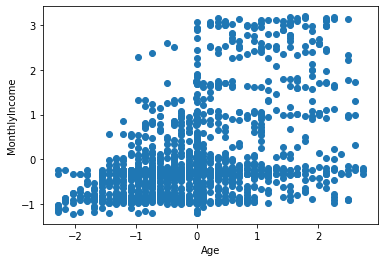

In [262]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel("Age")
plt.ylabel("MonthlyIncome")
plt.show()

In [263]:
#Riproduco l'algoritmo 10 volte e mi farà vedere l'output con il minore SSE
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=2)

In [264]:
#Numero di punti per ogni cluster
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1]), array([ 307, 1163], dtype=int64))

In [265]:
kmeans.labels_

array([1, 1, 0, ..., 1, 1, 0])

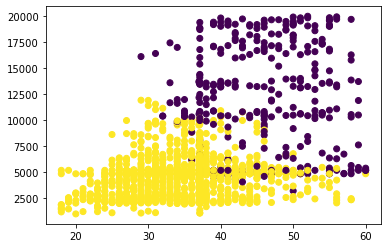

In [266]:
plt.scatter(df["Age"], df["MonthlyIncome"], c=kmeans.labels_)
plt.show()

In [267]:
kmeans.cluster_centers_

array([[ 1.06651535,  1.47709719,  0.03147774,  1.04063528, -0.03768083],
       [-0.28153071, -0.38991302, -0.00830926, -0.27469908,  0.0099467 ]])

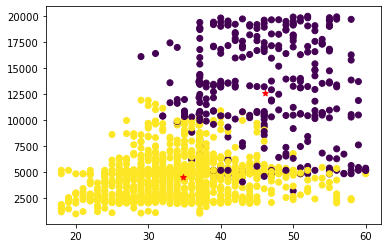

In [268]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(df["Age"], df["MonthlyIncome"], c=kmeans.labels_)
plt.scatter(centers[:,0], centers[:,1], marker="*", c="red")

plt.show()

**CALCOLO SSE**

In [269]:
sse_list = []
max_k = 50

for k in range(2, max_k+1):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    sse=kmeans.inertia_
    sse_list.append(sse)

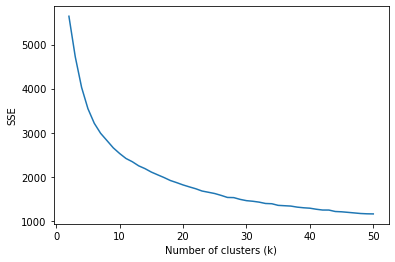

In [270]:
plt.plot(range(2, len(sse_list)+2), sse_list)

plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()